## Group 4 - Members

* Shyam Akhil Nekkanti - 8982123
* Jun He (Helena) - 8903073
* Zheming Li (Brendan) - 8914152

### 1. Dataset Description

### Dataset from [Trending YouTube Video Statistics](https://www.kaggle.com/datasets/datasnaek/youtube-new)

* Format: CSV
* Contains data for multiple regions including US, GB, DE, CA, FR, RU, MX, KR, JP and IN.
* The dataset contains information about YouTube videos that have appeared in the trending tab in the US(mainly research). 
* It includes various attributes:

- video title 
- channel title 
- publication date 
- trending date 
- views 
- likes 
- dislikes 
- comments
- tags

Note: These fields allow for a comprehensive analysis of video performance, trends, and user engagement across different channels and categories. Key columns include publish_time for time-based analysis and category_id for content categorization.

### 2. Objective

The project focuses on **analyzing YouTube video trends over time** , aiming to uncover patterns in engagement metrics like views, likes, and comment counts. The hypothesis tests whether video characteristics like title keywords or publish time significantly impact a video's trend status. Using the YouTube dataset, we'll test whether specific features can **predict video success**, examining the time-based trends and user interaction metrics across various categories.

### 3. EDA - Describe the data, explore it, and provide insights about it.

In [118]:
# IMPORT REQUIRED LIBRARIES
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

In [119]:
# LOAD THE CATEGORIES JSON FILE AND CREATE A HASHMAP OF CATEGORY IDS

def load_category_mapping(json_file):
  with open(json_file, 'r') as f:
    category_data = json.load(f)
  formatted_categories = {int(item['id']): item['snippet']['title'] for item in category_data['items']}
  return formatted_categories

In [120]:
# READ THE YOUTUBE TRENDING VIDEO DATASET
def load_and_preprocess_data(csv_file, category_mapping):
  df = pd.read_csv(csv_file)

  # Convert dates
  df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
  df['publish_time'] = pd.to_datetime(df['publish_time'])

  # Add category names as a column using the hashmap we created.
  df['category_name'] = df['category_id'].map(category_mapping)

  # Create log-transformed columns for all the features we are considering
  numerical_cols = ['views', 'likes', 'dislikes', 'comment_count']
  for col in numerical_cols:
    df[f'log_{col}'] = np.log1p(df[col])

  # Add derived metrics
  df['likes_ratio'] = df['likes'] / (df['views'] + 1)
  df['dislikes_ratio'] = df['dislikes'] / (df['views'] + 1)
  df['comment_ratio'] = df['comment_count'] / (df['views'] + 1)
  return df

In [121]:
# Calculate trending duration for each video
def calc_trending_duration(df):
  trending_counts = df.groupby('video_id').size().reset_index(name='trending_duration')
  df = df.merge(trending_counts, on='video_id', how='left')
  return df

In [122]:
def plot_moving_average(df, window_size=12):
        """Plots the moving average of the time series data to smooth fluctuations."""
        if df.time_series_data is None:
            print("Please generate the time series data first.")
            return
        
        # Calculate the moving average
        moving_avg = df.time_series_data.rolling(window=window_size).mean()
        
        # Plot the original time series and the moving average
        plt.figure(figsize=(10,6))
        plt.plot(df.time_series_data, label='Original Time Series', color='blue')
        plt.plot(moving_avg, label=f'{window_size}-day Moving Average', color='red')
        plt.title(f'Moving Average of YouTube Video Views ({window_size} Days)')
        plt.xlabel('Date')
        plt.ylabel('Views')
        plt.legend()
        plt.grid(True)
        plt.show()

In [123]:
def deseasonalize(df, time_series):
        # Deseasonalize by subtracting the moving average
        seasonal_component = time_series.rolling(window=12).mean()
        deseasonalized_series = time_series - seasonal_component
        return deseasonalized_series

In [124]:
# Load the csv dataset into a dataframe
category_mapping = load_category_mapping('youtube-dataset/US_category_id.json')
df = load_and_preprocess_data('youtube-dataset/USvideos.csv', category_mapping)



print(f"Loaded {len(df)} records")
print("\nDataset Overview:")

df.head(10)

Loaded 40949 records

Dataset Overview:


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,video_error_or_removed,description,category_name,log_views,log_likes,log_dislikes,log_comment_count,likes_ratio,dislikes_ratio,comment_ratio
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,...,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,13.525659,10.960027,7.995307,9.677528,0.076869,0.003963,0.021318
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13 07:30:00+00:00,"last week tonight trump presidency|""last week ...",2418783,97185,6146,...,False,"One year after the presidential election, John...",Entertainment,14.698775,11.484382,8.723719,9.449672,0.040179,0.002541,0.005252
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12 19:05:24+00:00,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,...,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,Comedy,14.975981,11.891595,8.582981,9.009692,0.045758,0.001673,0.002563
3,puqaWrEC7tY,2017-11-14,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13 11:00:04+00:00,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,...,False,Today we find out if Link is a Nickelback amat...,Entertainment,12.745978,9.227492,6.502790,7.671827,0.029641,0.001941,0.006253
4,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12 18:01:41+00:00,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,...,False,I know it's been a while since we did this sho...,Entertainment,14.555413,11.792343,7.595890,9.771041,0.063097,0.000949,0.008359
5,gHZ1Qz0KiKM,2017-11-14,2 Weeks with iPhone X,iJustine,28,2017-11-13 19:07:23+00:00,"ijustine|""week with iPhone X""|""iphone x""|""appl...",119180,9763,511,...,False,Using the iPhone for the past two weeks -- her...,Science & Technology,11.688399,9.186457,6.238325,7.268920,0.081917,0.004288,0.012032
6,39idVpFF7NQ,2017-11-14,Roy Moore & Jeff Sessions Cold Open - SNL,Saturday Night Live,24,2017-11-12 05:37:17+00:00,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",2103417,15993,2445,...,False,Embattled Alabama Senate candidate Roy Moore (...,Entertainment,14.559074,9.679969,7.802209,7.586296,0.007603,0.001162,0.000937
7,nc99ccSXST0,2017-11-14,5 Ice Cream Gadgets put to the Test,CrazyRussianHacker,28,2017-11-12 21:50:37+00:00,"5 Ice Cream Gadgets|""Ice Cream""|""Cream Sandwic...",817732,23663,778,...,False,Ice Cream Pint Combination Lock - http://amzn....,Science & Technology,13.614291,10.071710,6.658011,8.141190,0.028937,0.000951,0.004197
8,jr9QtXwC9vc,2017-11-14,The Greatest Showman | Official Trailer 2 [HD]...,20th Century Fox,1,2017-11-13 14:00:23+00:00,"Trailer|""Hugh Jackman""|""Michelle Williams""|""Za...",826059,3543,119,...,False,"Inspired by the imagination of P.T. Barnum, Th...",Film & Animation,13.624423,8.173011,4.787492,5.831882,0.004289,0.000144,0.000412
9,TUmyygCMMGA,2017-11-14,Why the rise of the robots won’t mean the end ...,Vox,25,2017-11-13 13:45:16+00:00,"vox.com|""vox""|""explain""|""shift change""|""future...",256426,12654,1363,...,False,"For now, at least, we have better things to wo...",News & Politics,12.454599,9.445808,7.218177,7.770223,0.049347,0.005315,0.009235


In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   video_id                40949 non-null  object             
 1   trending_date           40949 non-null  datetime64[ns]     
 2   title                   40949 non-null  object             
 3   channel_title           40949 non-null  object             
 4   category_id             40949 non-null  int64              
 5   publish_time            40949 non-null  datetime64[ns, UTC]
 6   tags                    40949 non-null  object             
 7   views                   40949 non-null  int64              
 8   likes                   40949 non-null  int64              
 9   dislikes                40949 non-null  int64              
 10  comment_count           40949 non-null  int64              
 11  thumbnail_link          40949 non-null  o

We added a new feature, `total_trending_days`, which shows how many days each video appeared on the trending list.

In [126]:
df = calc_trending_duration(df)
df['trending_duration'].describe()

count    40949.000000
mean         9.790300
std          5.763963
min          1.000000
25%          6.000000
50%          8.000000
75%         13.000000
max         30.000000
Name: trending_duration, dtype: float64

C:\Windows\Temp\ipykernel_29220\4255722825.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  daily_views = df['views'].resample('Y').sum()


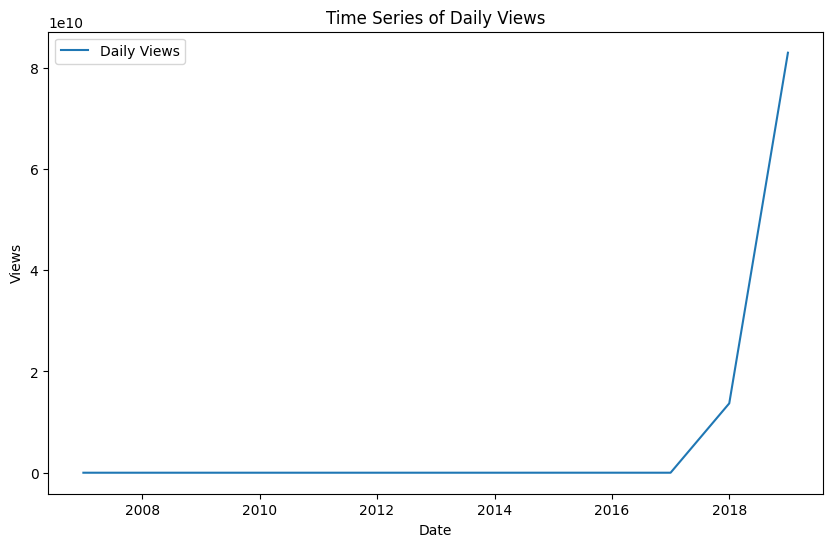

In [127]:
# find two samples
# step 1 convert 'publish_time' to datetime format
df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
# # df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m')
# # Step 2: Set 'publish_time' as index
df.set_index('publish_time', inplace=True)

# Step 3: Resample the data to daily counts or another time frequency
# Example: Resample by day, summing the views per day
daily_views = df['views'].resample('Y').sum()

# Step 4: Plot the data
plt.figure(figsize=(10, 6))
plt.plot(daily_views, label='Daily Views')
plt.xlabel('Date')
plt.ylabel('Views')
plt.title('Time Series of Daily Views')
plt.legend()
plt.show()

## 4. Hypothesis Testing

### Choosing the Test

Since we are comparing the total trending days across multiple categories, we will use the `ANOVA test`.

### Hypotheses

We proposed the following hypotheses:

* **Null Hypothesis (H<sub>0</sub>):** The time of video publication has no significant impact on the number of views a video receives.

* **Alternative Hypothesis (H<sub>a</sub>):** The time of video publication significantly impacts the number of views a video receives.

#### Why ANOVA?

ANOVA is suitable because it compares the means of total_trending_days across **multiple** video categories to determine significant differences.

#### Why not other tests?

* Because we are comparing the means of more than two groups, we cannot use `T-test` or `Wilcoxon signed-rank test`.
* Chi-square test is used for comparing categorical variables, which is not suitable for this case.
* F-test is used for comparing the variances of two groups, which is also not suitable for this case.

### Perform ANOVA test

In [128]:
# extract trending_duration data for each category, grouped by category
category_groups = []

for category in df['category_id'].unique():
  # Get all trending_duration data for the current category
  filter = df['category_id'] == category
  category_data = df[filter]['trending_duration']

  # Add the data to the list of category groups
  category_groups.append(category_data.values)

# Perform the ANOVA test to determine if the means of the groups are significantly different
statistic, p_value = stats.f_oneway(*category_groups)

print(f'P-value: {p_value:.3f}')

P-value: 0.000



The p-value is less than 0.05, which indicates that we reject the null hypothesis. Therefore, we can conclude that there is a significant difference in the mean of total trending days across different video categories.

In [130]:
def generate_time_series(df, column='views', freq='M'):
        # Resample the data to the desired frequency (monthly or yearly)
        time_series = df[column].resample(freq).sum()
        return time_series

## 5. Time Series Display

In [131]:
time_series_views = generate_time_series(df, 'M', 'views')
plt.figure(figsize=(10, 6))
plt.plot(time_series_views, label='Monthly Views')
plt.title('Monthly Views of Trending YouTube Videos')
plt.xlabel('Date')
plt.ylabel('Total Views')
plt.legend()
plt.show()

KeyError: 'M'

## 6.Identify a pattern or trend in the time series

 From the monthly views time series, we can observe periodic spikes, 
 likely around the holiday season or during special events. 
 This pattern suggests that video viewership tends to increase at certain times of the year, indicating a potential seasonal trend.

## 7.Calculate and plot the Moving Averages from the time series

In [138]:
plot_moving_average(df, window_size=12) 

AttributeError: 'DataFrame' object has no attribute 'time_series_data'

## 8.Technical Statement

After observing the time series plot and its moving average, the trend seems to show a consistent pattern of growth over time with periodic fluctuations. This suggests that the time series exhibits an additive pattern, as the seasonal fluctuations appear to remain constant regardless of the level of the trend.

## 9.Calculate and plot the Moving Averages from the time series

In [ ]:
deseasonalized_views = deseasonalize(time_series_views)
plt.figure(figsize=(10, 6))
plt.plot(deseasonalized_views, label='Deseasonalized Views')
plt.title('Deseasonalized Time Series of Monthly Views')
plt.xlabel('Date')
plt.ylabel('Deseasonalized Views')
plt.legend()
plt.show()

## Conclusion:
### Hypothesis Testing:
We are testing the hypothesis that the time of publication significantly impacts the number of views a video receives. The Null Hypothesis (H₀) assumes no impact, while the Alternative Hypothesis (H₁) suggests a significant impact.

### Time Series Analysis:
We have generated a time series of monthly views from the YouTube dataset. The trend shows periodic spikes, suggesting a seasonal pattern. To further analyze the trend, we calculate and plot the moving average and deseasonalize the series.
